In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm

In [2]:
sns.set_theme(style='whitegrid')

In [3]:
#--- Connect to sqlite database
conn = sqlite3.connect('./FPA_FOD_20170508.sqlite')
cursor = conn.cursor()

#--- Store all tables in a dictionary
def sql2pd(tables,conn):
    df = {}
    for table in tables:
        try: 
            query = "SELECT * FROM "+table
            df[table] = pd.read_sql_query(query, conn)
        except:
            pass
    return df

SQLquery = "SELECT name FROM sqlite_master WHERE type='table'"
tables = cursor.execute(SQLquery).fetchall()
tables = [table[0] for table in tables]
df = sql2pd(tables,conn)

In [4]:
#-- Use Table "Fires"
Fire = df['Fires']

#-- SELECT * From Fires WHERE 'STATE' = 'CA'
California = Fire[Fire['STATE'] == 'CA']

#-- Clearup the table
California = California[['DISCOVERY_DOY',
                         'DISCOVERY_DATE',
                         'LATITUDE',
                         'LONGITUDE',
                         'FIRE_YEAR',
                         'FIRE_SIZE_CLASS',
                         'STAT_CAUSE_DESCR']].drop_duplicates().dropna()

#-- Set Julian Date to Date
California = California.rename(columns={'DISCOVERY_DATE': 'DISCOVERY_DATE_julian'})
California['DISCOVERY_DATE'] = pd.to_datetime(California['DISCOVERY_DATE_julian'] - pd.Timestamp(0).to_julian_date(), unit='D')

Text(0.5, 1.0, 'Frequency of California Wildfire')

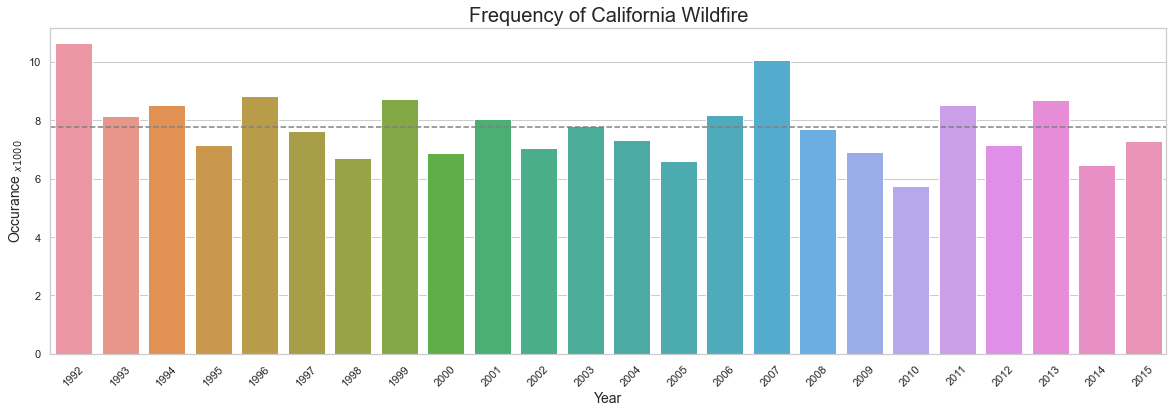

In [5]:
#-- frequency in Year, based on 'FIRE_YEAR'
Trend = California[['FIRE_YEAR','FIRE_SIZE_CLASS']]
Occurance = Trend.groupby('FIRE_YEAR').size()

#-- Take average of Occurance. 
mean=Occurance.mean()

#-- Plot the trend in frequency
plt.figure(figsize=(20,6))
graph = sns.barplot(x=Occurance.index, y=Occurance.values/1000)
graph.axhline(y=mean/1000,color='gray',linestyle='--')

plt.xticks(rotation=45)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Occurance $_{x 1000}$', fontsize=14)
plt.title('Frequency of California Wildfire',fontsize=20)

In [6]:
print(Occurance.describe(),'\n')
print(California.FIRE_SIZE_CLASS.value_counts(),'\n')

count       24.000000
mean      7783.500000
std       1131.256324
min       5744.000000
25%       7007.000000
50%       7671.000000
75%       8528.000000
max      10636.000000
dtype: float64 

A    96548
B    76007
C     9784
D     2130
E     1185
F      756
G      394
Name: FIRE_SIZE_CLASS, dtype: int64 



Text(0.5, 1.0, 'Frequency of California Wildfire')

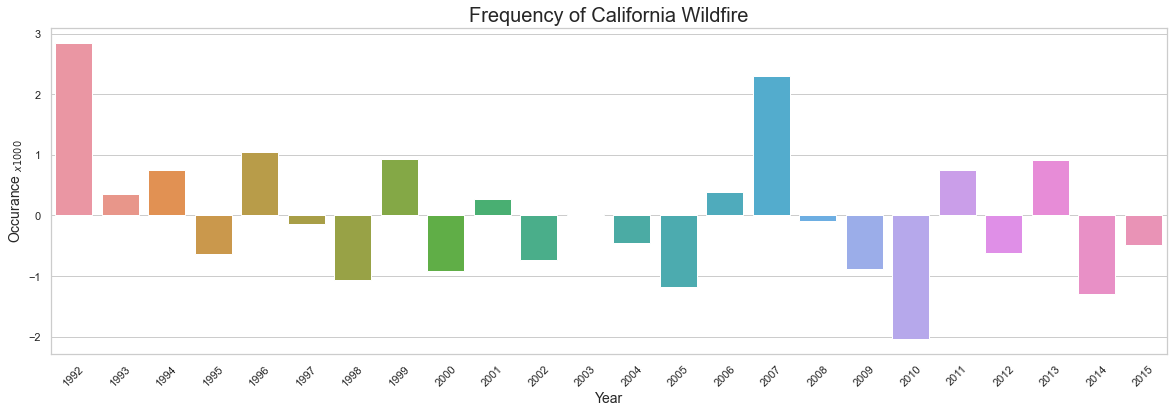

In [7]:
#-- detrend, maybe is easy to check the annually pattern.
plt.figure(figsize=(20,6))
graph = sns.barplot(x=Occurance.index, y=(Occurance.values-mean)/1000)
plt.xticks(rotation=45)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Occurance $_{x 1000}$', fontsize=14)
plt.title('Frequency of California Wildfire',fontsize=20)

# print(Occurance,'\n')

<br/><br/> 

Let's compare with Niño 3.4 index

### Niño 3.4 index
![El Nino/La Nina Index](./oni.monthly.smoo_stro.png)
cite: https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
<br/><br/> 

---
---
## Month of Year

In [8]:
Month = California.groupby(pd.Grouper(key='DISCOVERY_DATE', freq='1M')).FIRE_YEAR.size() 
Month.index = Month.index.strftime('%Y-%b')

Text(0.5, 0, 'DISCOVERY DATE')

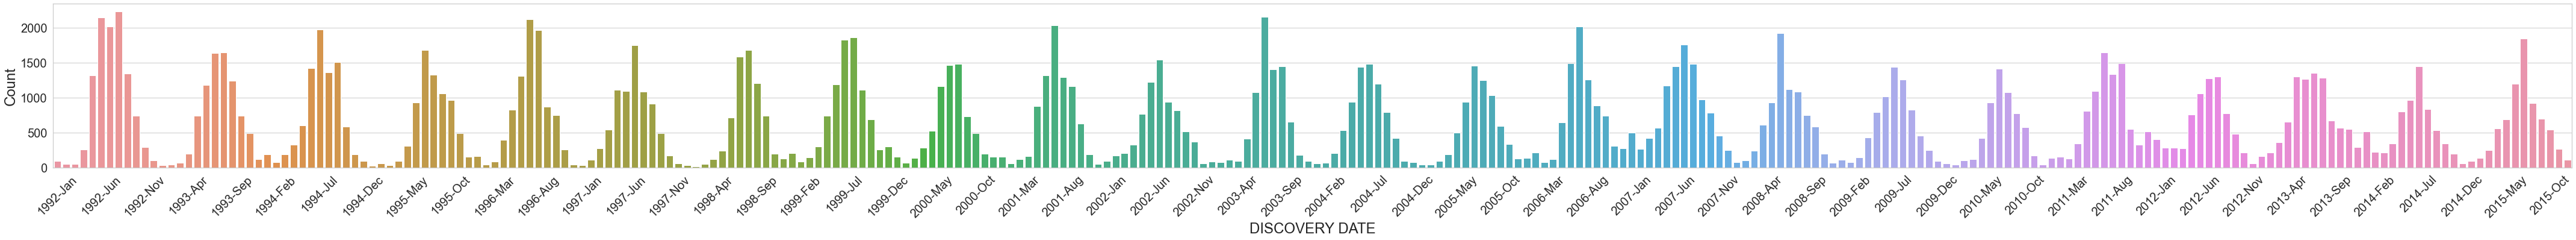

In [9]:
plt.figure(figsize=(75, 5))
graph = sns.barplot(x=Month.index, y=Month.values)
graph.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Count',fontsize=24)
plt.xlabel('DISCOVERY DATE',fontsize=24)

In [10]:
Month2 = California.groupby(pd.Grouper(key='DISCOVERY_DATE', freq='1M')).FIRE_YEAR.size() 
Month2.index = Month2.index.strftime('%b')
Month2 = Month2.reset_index().rename(columns={'DISCOVERY_DATE':'Month'})

Text(0.5, 0, 'Month')

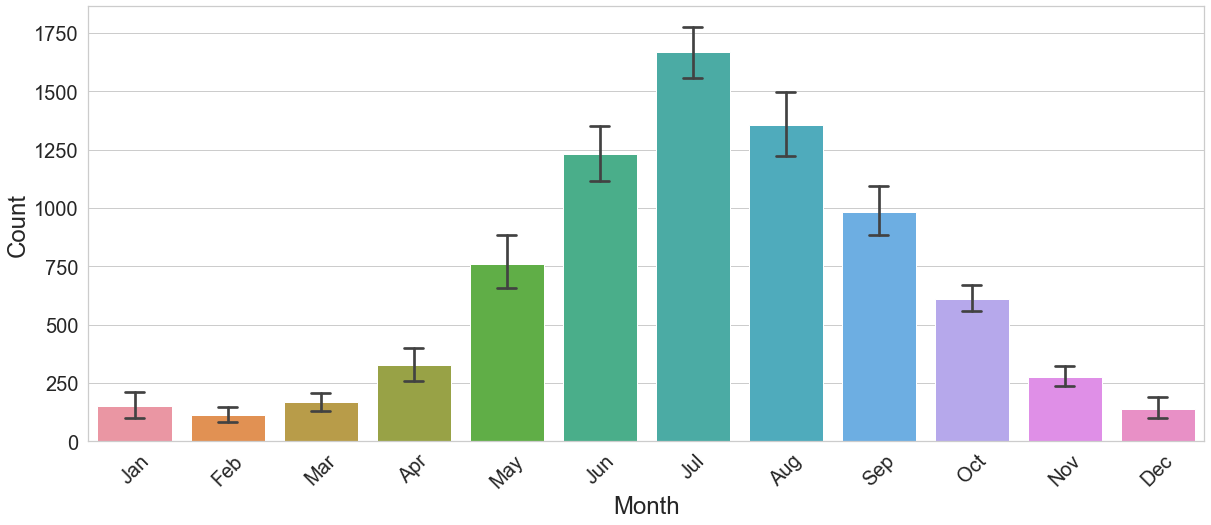

In [11]:
plt.figure(figsize=(20,8))
graph = sns.barplot(x='Month', y='FIRE_YEAR',data=Month2,capsize=.2)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Count',fontsize=24)
plt.xlabel('Month', fontsize=24)

---
---
## Day of Year

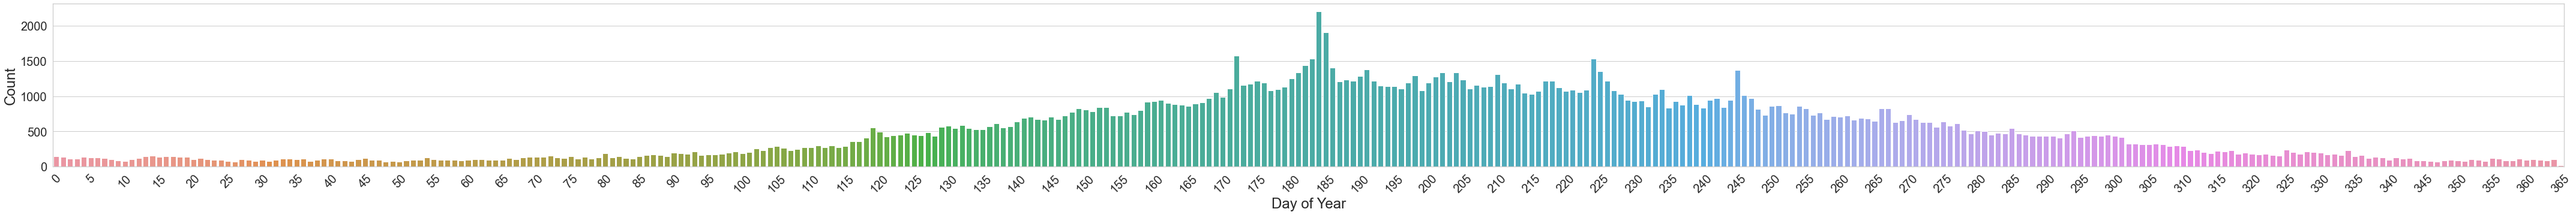

In [12]:
plt.figure(figsize=(75, 5))
graph=sns.countplot(x='DISCOVERY_DOY',data=California)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Count',fontsize=24)
plt.xlabel('Day of Year', fontsize=24)
graph.xaxis.set_major_locator(ticker.MultipleLocator(5))
graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

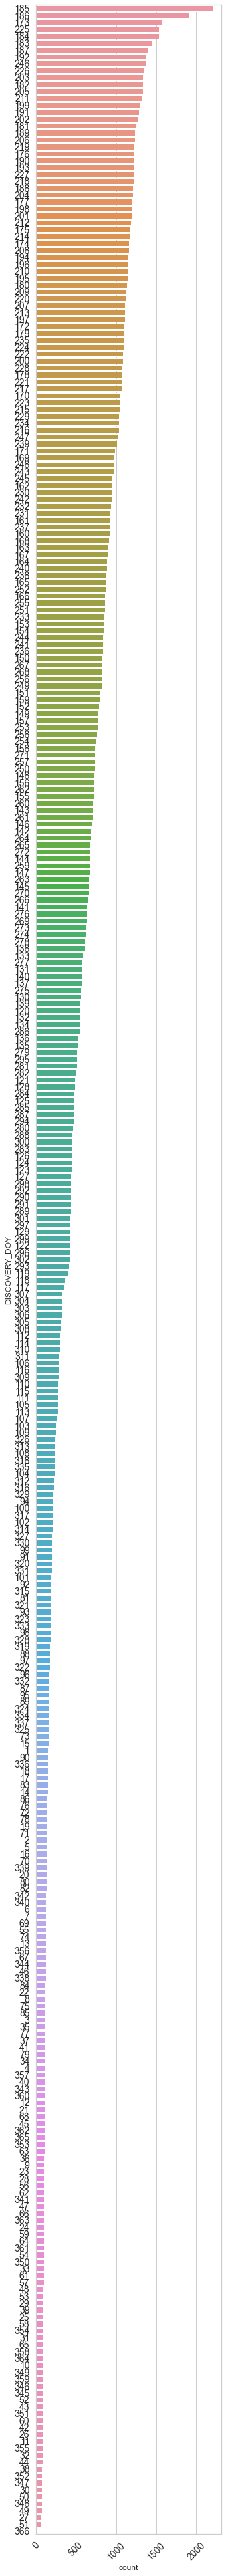

In [13]:
plt.figure(figsize=(5, 70))
p=sns.countplot(y='DISCOVERY_DOY',order=California.DISCOVERY_DOY.value_counts().index,data=California)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

---
---
### Trend in SEVERITY

note:  the label of the FIRE_SIZE_CLASS  
- A=greater than 0 but less than or equal to 0.25 acres,  
- B=0.26-9.9 acres,  
- C=10.0-99.9 acres,  
- D=100-299 acres,  
- E=300 to 999 acres,  
- F=1000 to 4999 acres, and  
- G=5000+ acres  

<ipython-input-14-646b8318c451>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  PIC.xaxis.set_ticklabels(range(1991,2016))


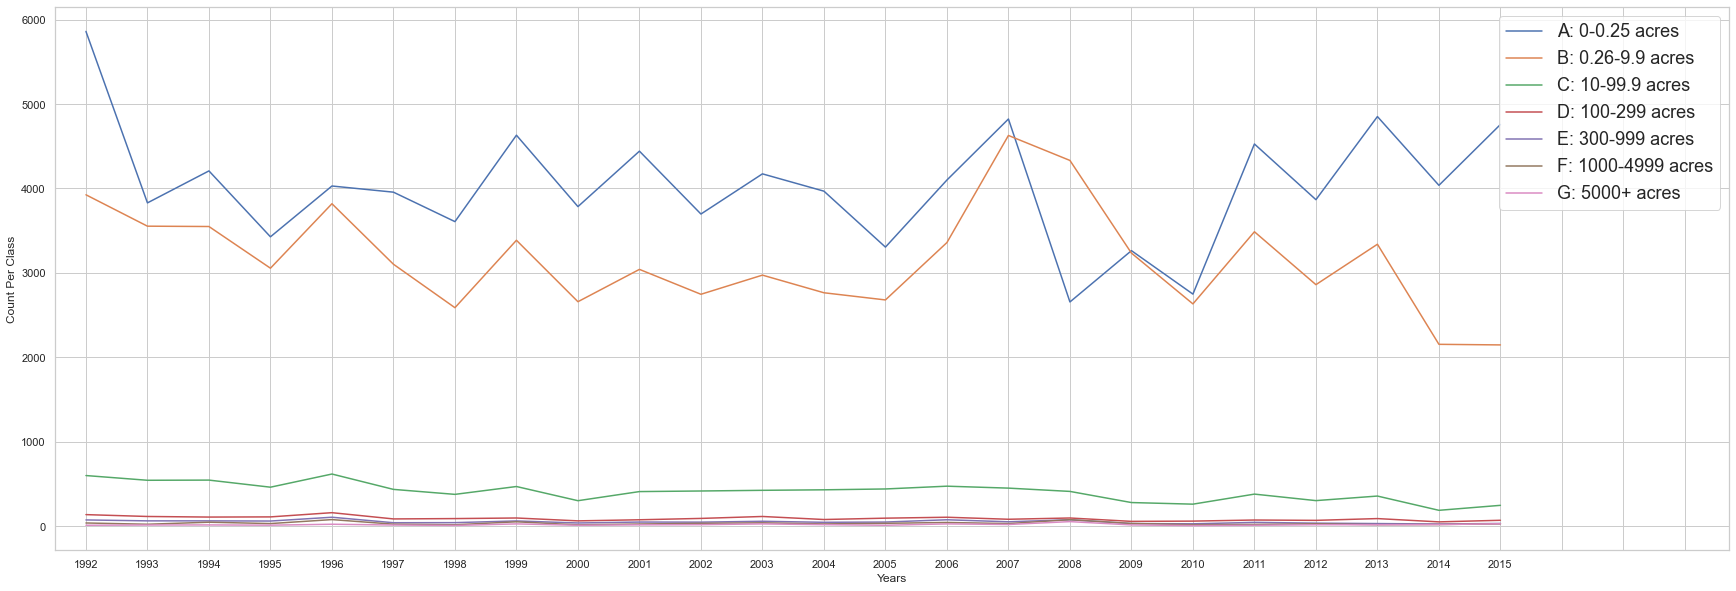

In [14]:
#-- Based on Year

FIRE_GROUP=California[['FIRE_YEAR','FIRE_SIZE_CLASS']]
PIC = FIRE_GROUP.groupby('FIRE_YEAR').FIRE_SIZE_CLASS.value_counts().unstack().plot(figsize=(30,10))
PIC.set_xlim(1991.5,2018.72)
PIC.xaxis.set_major_locator(ticker.MultipleLocator(1))
PIC.xaxis.set_ticklabels(range(1991,2016))
PIC.legend(loc='upper right',labels=['A: 0-0.25 acres',
                              'B: 0.26-9.9 acres',
                              'C: 10-99.9 acres',
                              'D: 100-299 acres',
                              'E: 300-999 acres',
                              'F: 1000-4999 acres',
                              'G: 5000+ acres'],
           fontsize=18
          )
plt.xlabel('Years')
plt.ylabel('Count Per Class')
plt.show()

In [15]:
#to show you the magic offf unsatckkk...
fire_g=FIRE_GROUP.groupby('FIRE_YEAR').FIRE_SIZE_CLASS.value_counts()
print(fire_g.unstack())

FIRE_SIZE_CLASS     A     B    C    D    E   F   G
FIRE_YEAR                                         
1992             5861  3925  598  135   72  36   9
1993             3829  3553  542  113   61  21  12
1994             4208  3549  544  106   61  45  13
1995             3427  3055  460  108   59  29  10
1996             4029  3819  616  158  104  76  21
1997             3956  3102  434   84   39  22  12
1998             3607  2587  375   88   40  15   7
1999             4631  3386  468   95   60  50  25
2000             3785  2658  300   61   36  14   9
2001             4442  3041  408   74   47  24  14
2002             3697  2746  415   90   46  32  16
2003             4173  2973  423  113   56  38  25
2004             3968  2764  429   77   44  25  16
2005             3305  2679  439   93   47  32   9
2006             4100  3359  472  104   74  42  25
2007             4823  4628  449   80   50  29  18
2008             2655  4332  410   95   74  75  52
2009             3263  3234  27

In [16]:
Month = California.groupby([pd.Grouper(key='DISCOVERY_DATE', freq='1M'),pd.Grouper(key='FIRE_SIZE_CLASS')]).size() 
Month.index = Month.index.set_levels([Month.index.levels[0].strftime('%Y-%b'), Month.index.levels[1]])

<ipython-input-17-82e4eda30368>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  abc.xaxis.set_ticklabels(range(1991,2017))


Text(0.5, 0, 'DISCOVERY DATE')

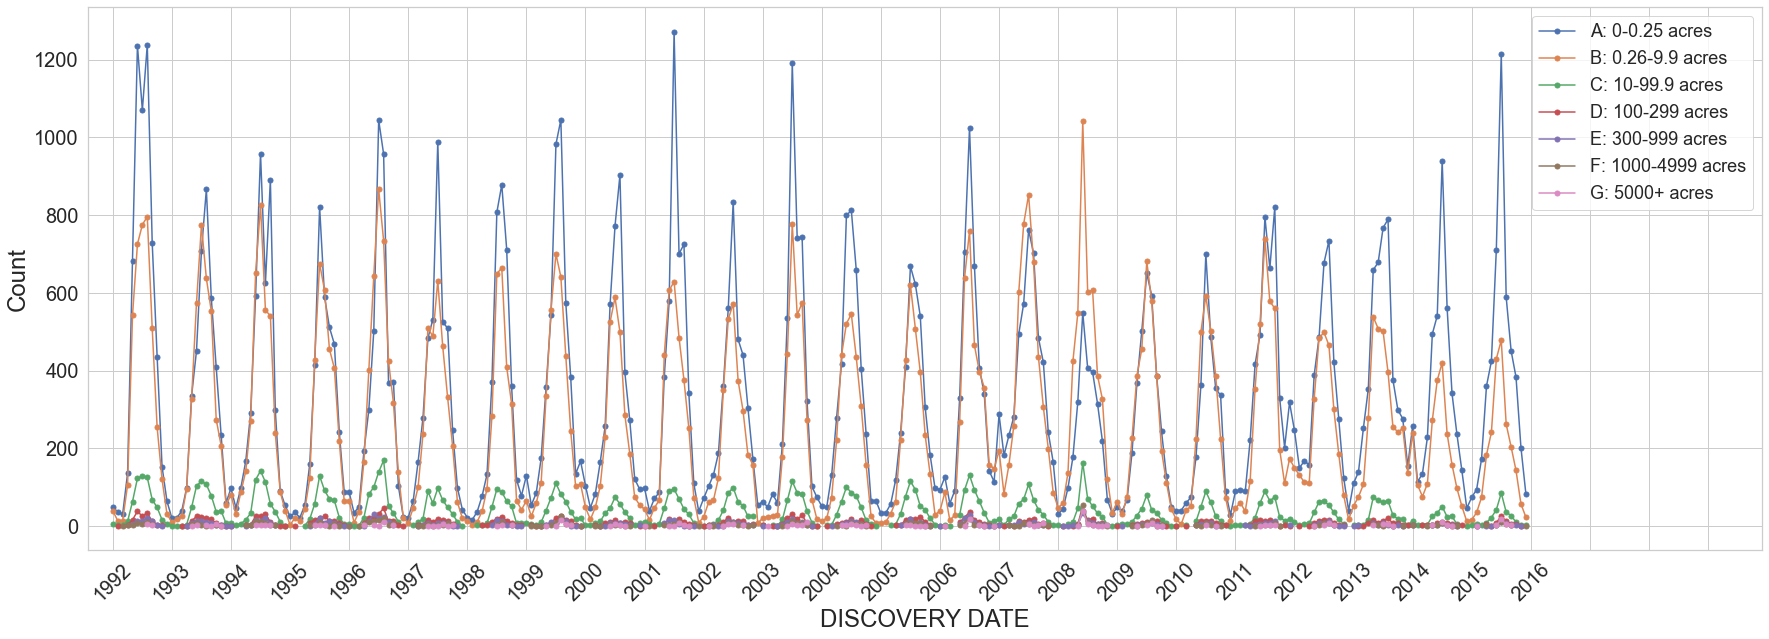

In [17]:
abc = Month.unstack(level=1).plot(style='.-',markersize=10,figsize=(30,10))
abc.xaxis.set_major_locator(ticker.MultipleLocator(12))
abc.xaxis.set_ticklabels(range(1991,2017))
plt.xlim(-5,335)
abc.legend(loc='upper right',labels=['A: 0-0.25 acres',
                              'B: 0.26-9.9 acres',
                              'C: 10-99.9 acres',
                              'D: 100-299 acres',
                              'E: 300-999 acres',
                              'F: 1000-4999 acres',
                              'G: 5000+ acres'],
           fontsize=18
          )
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Count',fontsize=24)
plt.xlabel('DISCOVERY DATE', fontsize=24)

<br/><br/> 

Let's compare with Niño 3.4 index again

### Niño 3.4 index
![El Nino/La Nina Index](./oni.monthly.smoo_stro.png)
cite: https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
<br/><br/> 

---
---
---
4. What are the major factors affecting frequency and severity of wildfires?

In [18]:
print(np.unique(Fire[['STAT_CAUSE_DESCR']]))

['Arson' 'Campfire' 'Children' 'Debris Burning' 'Equipment Use'
 'Fireworks' 'Lightning' 'Miscellaneous' 'Missing/Undefined' 'Powerline'
 'Railroad' 'Smoking' 'Structure']


Text(0.5, 66.453125, 'Cause Reason')

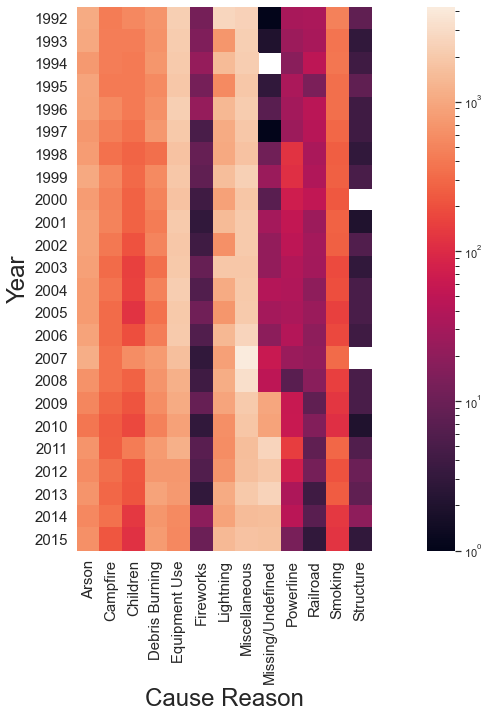

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(California.FIRE_YEAR, California.STAT_CAUSE_DESCR), square=True, norm=LogNorm())
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0,fontsize=15)
plt.ylabel('Year',fontsize=24)
plt.xlabel('Cause Reason', fontsize=24)

Text(0.5, 97.88389423076919, 'Cause Reason')

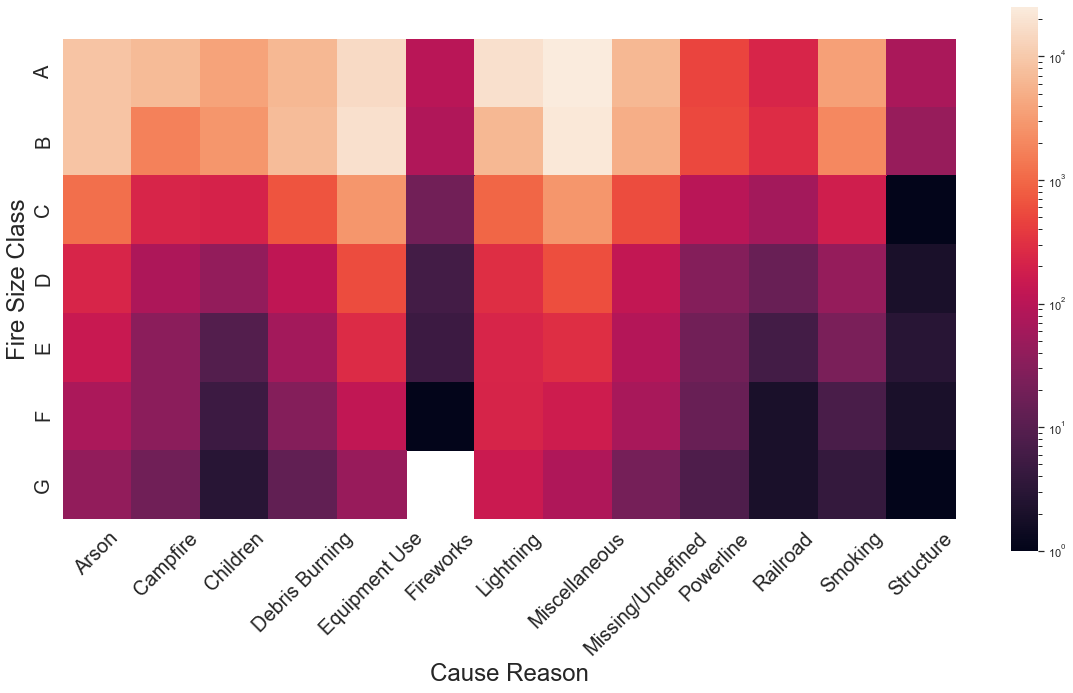

In [20]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(California.FIRE_SIZE_CLASS, California.STAT_CAUSE_DESCR),square=True, norm=LogNorm())
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Fire Size Class',fontsize=24)
plt.xlabel('Cause Reason', fontsize=24)

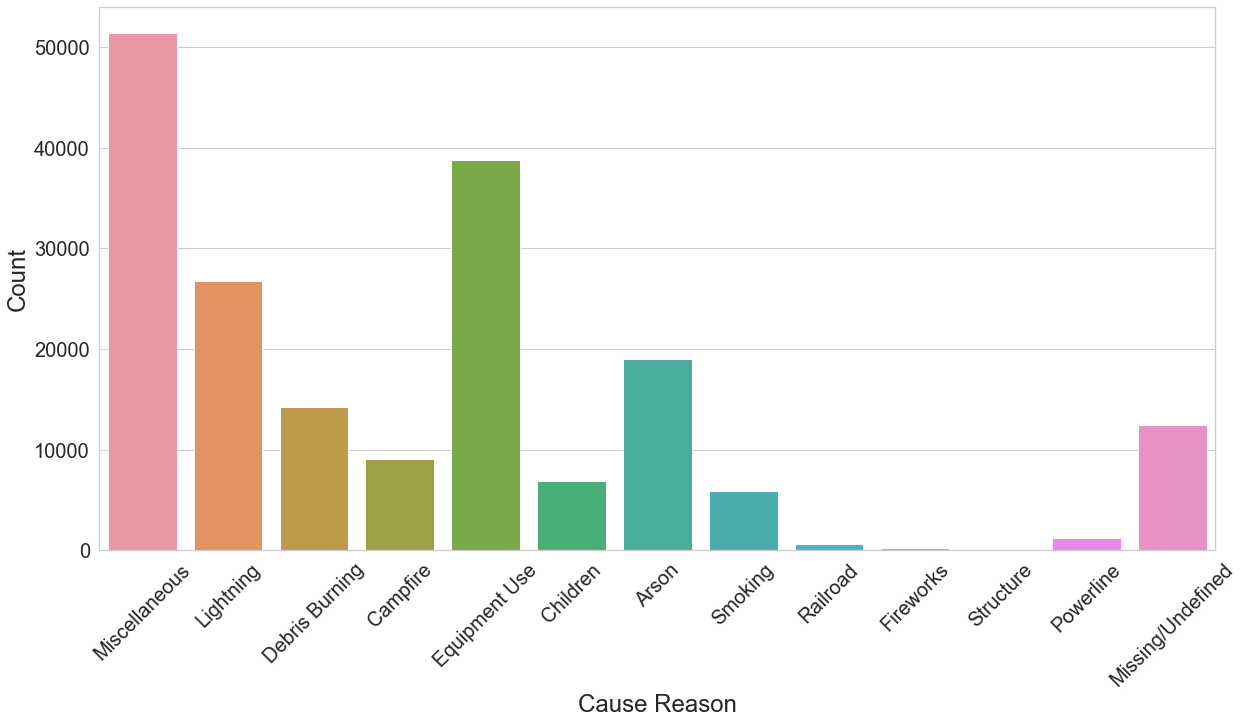

In [21]:
plt.figure(figsize=(20,10))
graph=sns.countplot(x='STAT_CAUSE_DESCR',data=California)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Count',fontsize=24)
plt.xlabel('Cause Reason', fontsize=24)
# graph.xaxis.set_major_locator(ticker.MultipleLocator(5))
# graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

<ipython-input-22-82e61db159d6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  PIC.xaxis.set_ticklabels(range(1991,2016))


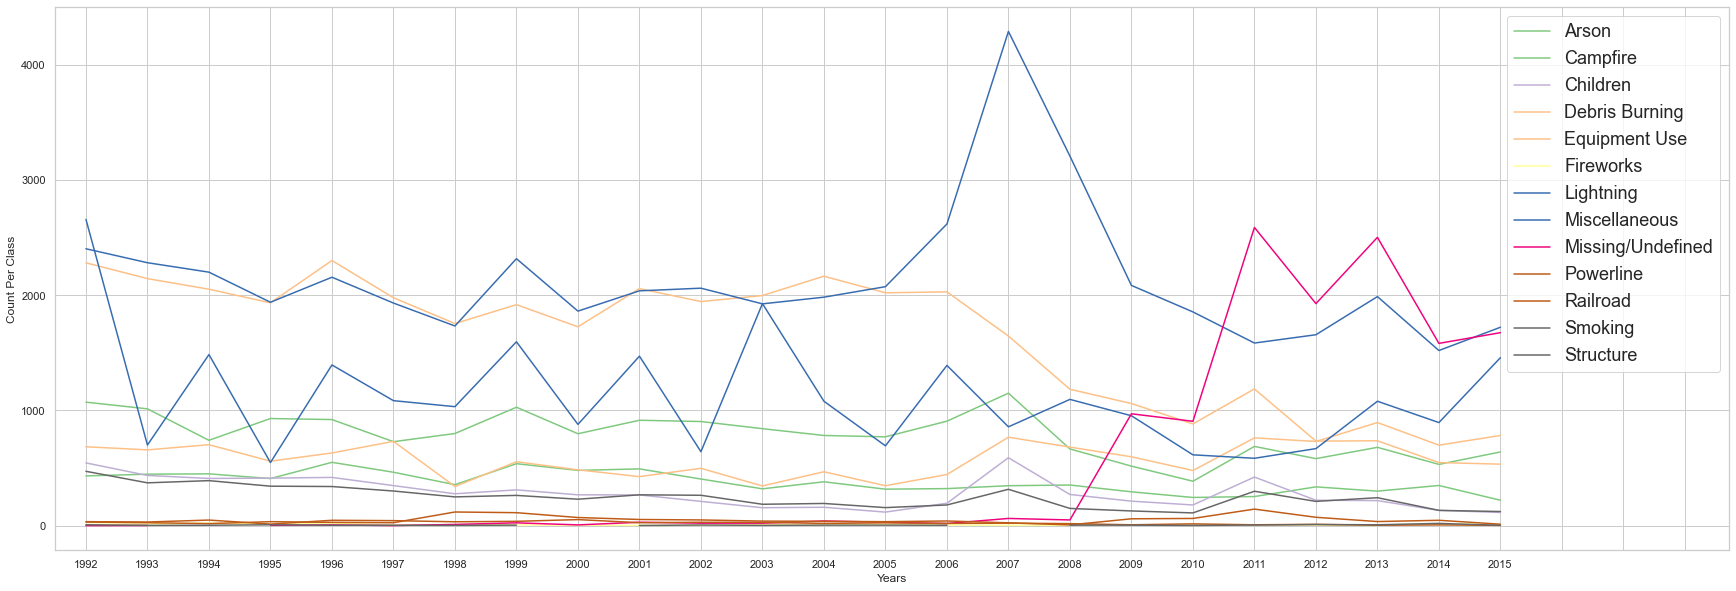

In [22]:
FIRE_GROUP=California[['FIRE_YEAR','STAT_CAUSE_DESCR']]
PIC = FIRE_GROUP.groupby('FIRE_YEAR').STAT_CAUSE_DESCR.value_counts().unstack().plot(figsize=(30,10),colormap='Accent')
PIC.set_xlim(1991.5,2018.72)
PIC.xaxis.set_major_locator(ticker.MultipleLocator(1))
PIC.xaxis.set_ticklabels(range(1991,2016))
PIC.legend(loc='upper right', fontsize=18)
plt.xlabel('Years')
plt.ylabel('Count Per Class')
plt.show()

In [23]:
Month = California.groupby([pd.Grouper(key='DISCOVERY_DATE', freq='1M'),pd.Grouper(key='FIRE_SIZE_CLASS'), pd.Grouper(key='STAT_CAUSE_DESCR')]).size() 
Month.index = Month.index.set_levels([Month.index.levels[0].strftime('%Y-%b'), Month.index.levels[1], Month.index.levels[2]])
# abc = Month.unstack(level=2).plot(style='.-',markersize=10,figsize=(30,10))
# abc.xaxis.set_major_locator(ticker.MultipleLocator(12))
# abc.xaxis.set_ticklabels(range(1991,2017))
# plt.xlim(-5,335)
# abc.legend(loc='upper right',labels=['A: 0-0.25 acres',
#                               'B: 0.26-9.9 acres',
#                               'C: 10-99.9 acres',
#                               'D: 100-299 acres',
#                               'E: 300-999 acres',
#                               'F: 1000-4999 acres',
#                               'G: 5000+ acres'],
#            fontsize=18
#           )
# plt.xticks(rotation=45, fontsize=20)
# plt.yticks(fontsize=20)
# plt.ylabel('Count',fontsize=24)
# plt.xlabel('DISCOVERY DATE', fontsize=24)
Month

DISCOVERY_DATE  FIRE_SIZE_CLASS  STAT_CAUSE_DESCR 
1992-Jan        A                Arson                 5
                                 Campfire              4
                                 Children              6
                                 Debris Burning        4
                                 Equipment Use        11
                                                      ..
2015-Dec        B                Miscellaneous        10
                                 Missing/Undefined     4
                C                Equipment Use         1
                                 Miscellaneous         1
                F                Missing/Undefined     1
Length: 8774, dtype: int64

<ipython-input-24-b9346ae345ed>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(1991,2017))
<ipython-input-24-b9346ae345ed>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(1991,2017))
<ipython-input-24-b9346ae345ed>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(1991,2017))
<ipython-input-24-b9346ae345ed>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(1991,2017))
<ipython-input-24-b9346ae345ed>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(1991,2017))
<ipython-input-24-b9346ae345ed>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(range(1991,2017))
<ipython-input-24-b9346ae345ed>:8: UserWarning: FixedFormatter should only b

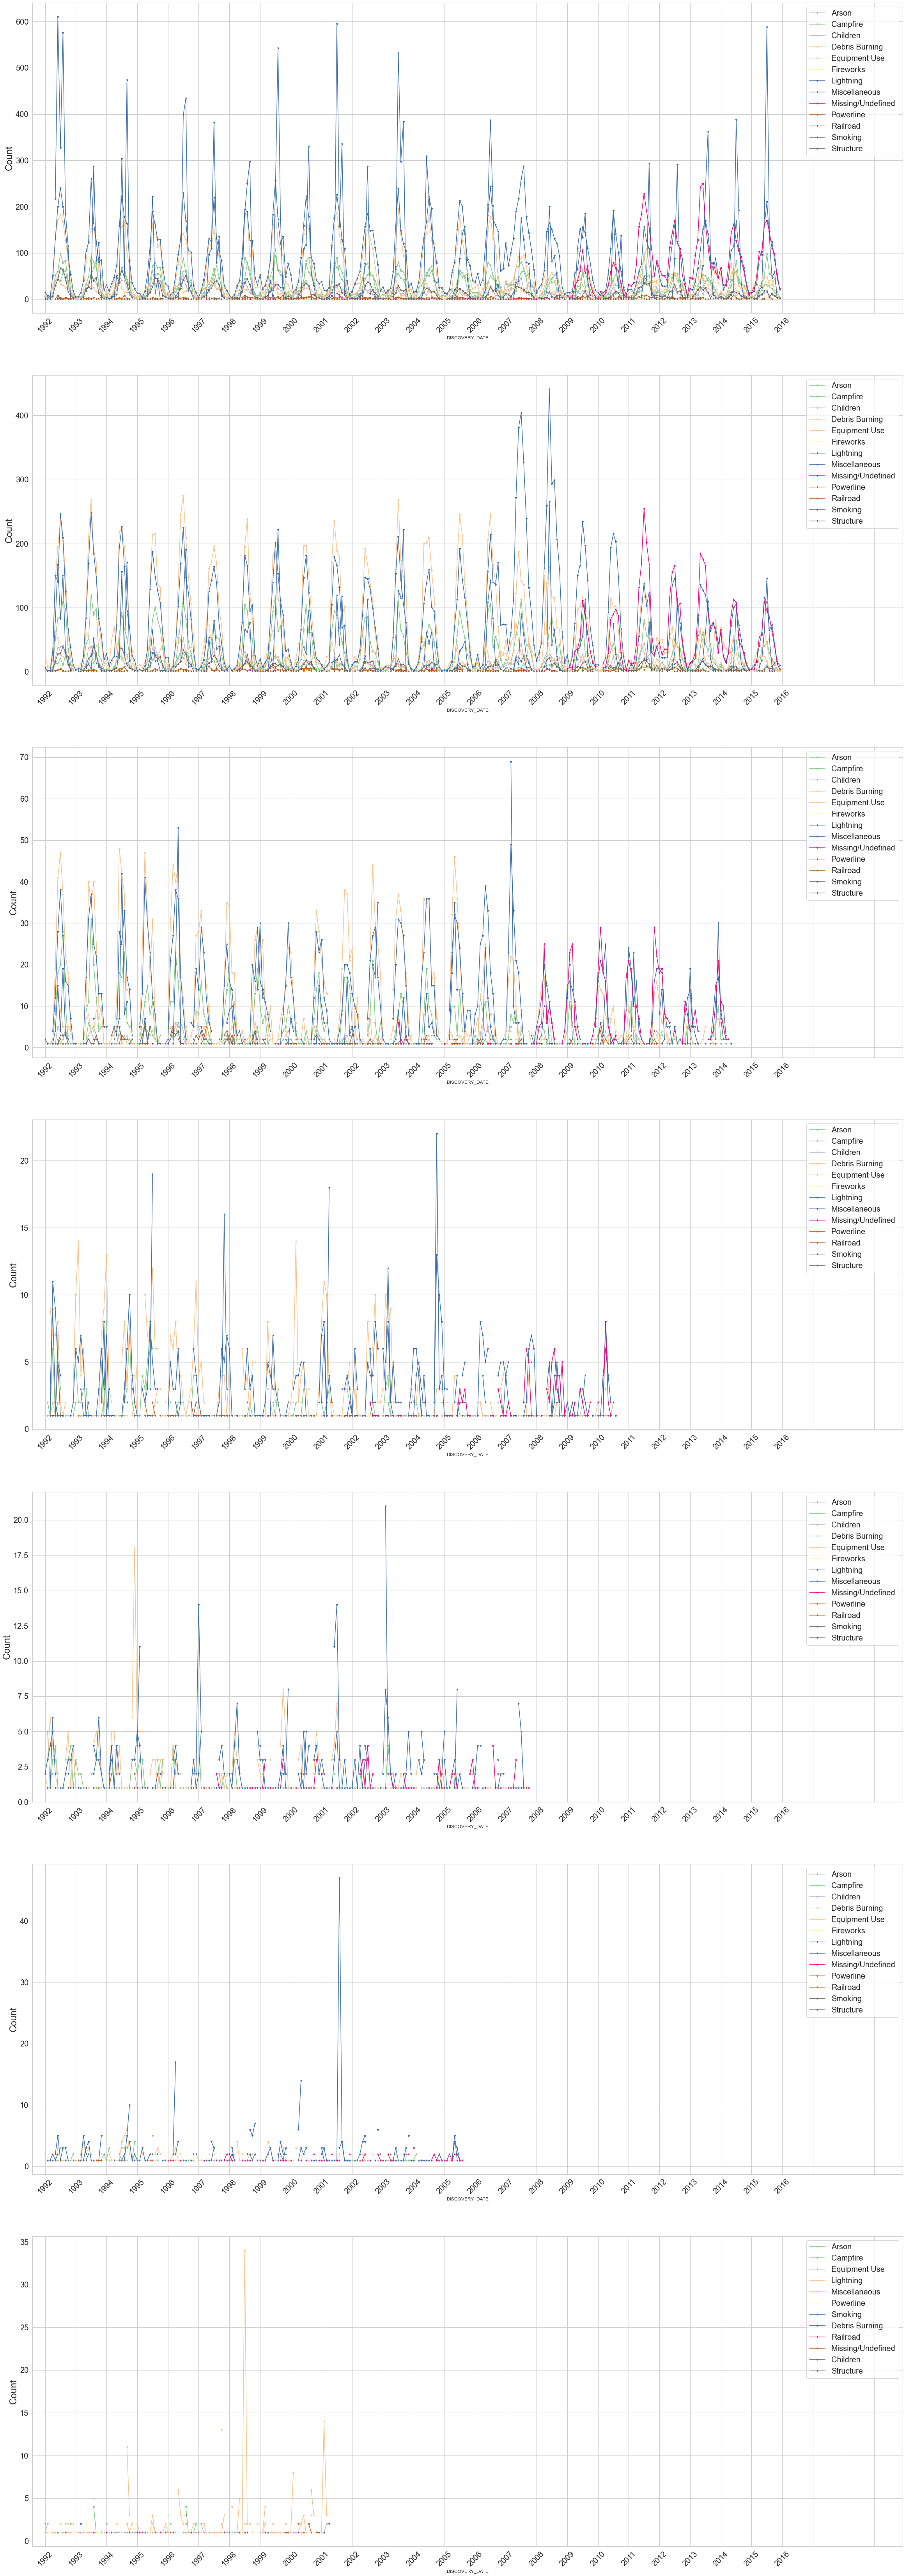

In [24]:
fig, axes = plt.subplots(ncols=1,nrows=7,figsize=(40,120))
for num, letter in enumerate(['A','B','C','D','E','F','G']):
    ax = axes.flat[num]
    Month.loc[:,letter,:].unstack(level=1).plot(style='*-',markersize=5,ax=ax,colormap='Accent')
    ax.tick_params('x', labelrotation=45, labelsize=20)
    ax.tick_params('y',labelsize=20)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
    ax.xaxis.set_ticklabels(range(1991,2017))  
    ax.set_xlim([-5,335])
    ax.set_ylabel('Count',fontsize=24)
    ax.legend(loc='upper right', fontsize=20)